# In Depth - Decision Trees and Forests

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Here we'll explore a class of algorithms based on decision trees.
Decision trees at their root are extremely intuitive.  They
encode a series of "if" and "else" choices, similar to how a person might make a decision.
However, which questions to ask, and how to proceed for each answer is entirely learned from the data.

For example, if you wanted to create a guide to identifying an animal found in nature, you
might ask the following series of questions:

- Is the animal bigger or smaller than a meter long?
    + *bigger*: does the animal have horns?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal have two or four legs?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

One of the main benefit of tree-based models is that they require little preprocessing of the data.
They can work with variables of different types (continuous and discrete) and are invariant to scaling of the features.

Another benefit is that tree-based models are what is called "nonparametric", which means they don't have a fix set of parameters to learn. Instead, a tree model can become more and more flexible, if given more data.
In other words, the number of free parameters grows with the number of samples and is not fixed, as for example in linear models.


## Decision Tree Classification

### Generate a simple dataset

In [1]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    centers=[[0, 0], [1, 1]], random_state=61526, n_samples=100
)

First, let's look at the generated data

In [4]:
classes = np.unique(y)
print(f"The class labels are: {classes}")

The class labels are: [0 1]


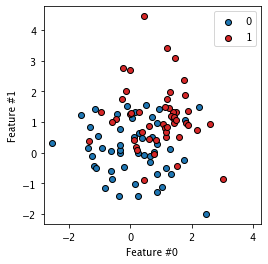

In [5]:
_, ax = plt.subplots()
for klazz, color in zip(classes, ["tab:blue", "tab:red"]):
    mask_sample_klazz = y == klazz
    ax.scatter(
        X[mask_sample_klazz, 0], X[mask_sample_klazz, 1],
        color=color, label=klazz,
        edgecolor="black",
    )
plt.axis("square")
plt.legend()
plt.xlabel("Feature #0")
_ = plt.ylabel("Feature #1")

We will create a function to create this scatter plot by passing 2 variables: `data` and `labels`.

In [6]:
def plot_data(data, labels, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    classes = np.unique(labels)
    for klazz, color in zip(classes, ["tab:blue", "tab:red"]):
        mask_sample_klazz = labels == klazz
        ax.scatter(
            data[mask_sample_klazz, 0], data[mask_sample_klazz, 1],
            color=color, label=klazz,
            edgecolor="black",
        )
    sns.despine()
    ax.axis("square")
    plt.legend()
    plt.xlabel("Feature #0")
    _ = plt.ylabel("Feature #1")
    return ax

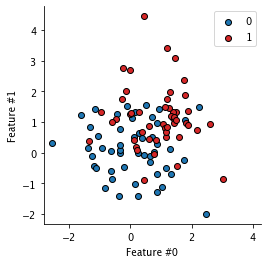

In [7]:
_ = plot_data(X, y)

### Train a decision tree classifier

We can learn a set of binary rules using a portion of the data. Using the rules learned, we will predict on the testing data.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1])

We can plot the decision boundaries found using the training data.

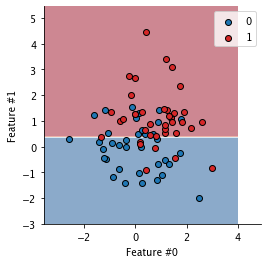

In [10]:
# from figures import DecisionBoundaryDisplay  # for scikit-learn < 1.2
from sklearn.inspection import DecisionBoundaryDisplay

display = DecisionBoundaryDisplay.from_estimator(
    clf, X, cmap=plt.cm.RdBu_r, alpha=0.5
)
_ = plot_data(X_train, y_train, ax=display.ax_)

Similarly, we get the following classification on the testing set.

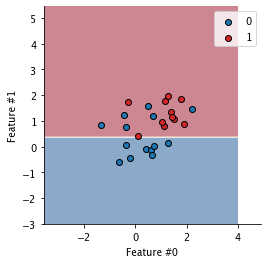

In [11]:
display = DecisionBoundaryDisplay.from_estimator(
    clf, X, cmap=plt.cm.RdBu_r, alpha=0.5
)
_ = plot_data(X_test, y_test, ax=display.ax_)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li> Modify the depth of the tree and see how the partitioning evolves. </li>
     <li>What can you say about under- and over-fitting of the tree model?</li>
     <li>How would you choose the best depth?</li>
     </ul>
</div>

There are many parameter that control the complexity of a tree, but the one that might be easiest to understand is the maximum depth. This limits how finely the tree can partition the input space, or how many "if-else" questions can be asked before deciding which class a sample lies in.

This parameter is important to tune for trees and tree-based models. The interactive plot below shows how underfit and overfit looks like for this model. Having a ``max_depth`` of 1 is clearly an underfit model, while a depth of 7 or 8 clearly overfits. The maximum depth a tree can be grown at for this dataset is 8, at which point each leave only contains samples from a single class. This is known as all leaves being "pure."

In the interactive plot below, the regions are assigned blue and red colors to indicate the predicted class for that region. The shade of the color indicates the predicted probability for that class (darker = higher probability), while yellow regions indicate an equal predicted probability for either class.

In [12]:
from figures import plot_tree_interactive
plot_tree_interactive()

interactive(children=(IntSlider(value=0, description='max_depth', max=8), Output()), _dom_classes=('widget-int…

### Aside note regarding the partitioning in decision tree

In this section, we will go slightly more into details regarding how a tree is selecting the best partition. First, instead of using synthetic data, we will use a real dataset this time.

In [13]:
dataset = pd.read_csv("datasets/penguins.csv")
dataset = dataset.dropna(subset=["Body Mass (g)"])
dataset.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
5,PAL0708,6,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,2007-11-16,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,NaN


We will build a decision tree to classify the penguin species using their body mass as a feature. To simplify the problem will focus only the Adelie and Gentoo species.

In [14]:
# Only select the column of interest
dataset = dataset[["Body Mass (g)", "Species"]]
# Make the species name more readable
dataset["Species"] = dataset["Species"].apply(lambda x: x.split()[0])
# Only select the Adelie and Gentoo penguins
dataset = dataset.set_index("Species").loc[["Adelie", "Gentoo"], :]
# Sort all penguins by their body mass
dataset = dataset.sort_values(by="Body Mass (g)")
# Convert the dataframe (2D) to a series (1D)
dataset = dataset.squeeze()
dataset

Species
Adelie    2850.0
Adelie    2850.0
Adelie    2900.0
Adelie    2900.0
Adelie    2900.0
           ...  
Gentoo    5950.0
Gentoo    6000.0
Gentoo    6000.0
Gentoo    6050.0
Gentoo    6300.0
Name: Body Mass (g), Length: 274, dtype: float64

We will first look at the body mass distribution for each species.

Text(0, 0.5, 'Probability')

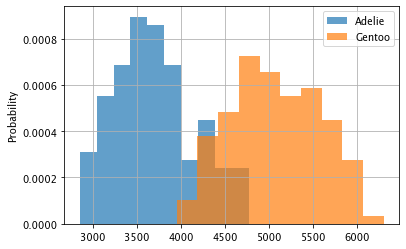

In [15]:
_, ax = plt.subplots()
dataset.groupby("Species").hist(ax=ax, alpha=0.7, legend=True, density=True)
ax.set_ylabel("Probability")

Instead of looking at the distribution, we can look at all samples directly.

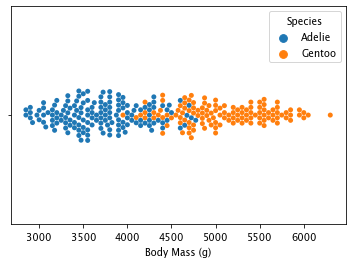

In [16]:
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
_ = ax.set_xlabel(dataset.name)

When we build a tree, we want to find splits, one at the time, such that partitions "unmix" the classes as much as possible. Let's make a first completely random split to highlight the principle.

In [17]:
# create a random state such we all have the same results
rng = np.random.RandomState(42)

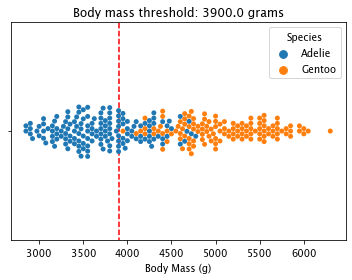

In [18]:
random_idx = rng.choice(dataset.size)

ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
ax.set_xlabel(dataset.name)
ax.set_title(f"Body mass threshold: {dataset[random_idx]} grams")
_ = ax.vlines(dataset[random_idx], -1, 1, color="red", linestyle="--")

We aim to obtain two partitions for which the samples come as much as possible from a single class and contain as many samples as possible. In decision trees, we use a **criterion** to assess the quality of a split. The **entropy** is one of the statistics which can describe the class mixity in a partition. Let's compute the entropy for the full dataset, the set on the left of the threshold and the set on the right.

In [19]:
from scipy.stats import entropy

In [22]:
dataset.index.value_counts()

Adelie    151
Gentoo    123
Name: Species, dtype: int64

In [23]:
parent_entropy = entropy(
    dataset.index.value_counts(normalize=True)
)
parent_entropy

0.6879166791258041

In [24]:
left_entropy = entropy(
    dataset[:random_idx].index.value_counts(normalize=True)
)
left_entropy

0.0

In [25]:
right_entropy = entropy(
    dataset[random_idx:].index.value_counts(normalize=True)
)
right_entropy

0.5975068586842202

We can see the quality of the split by combining the entropies. This is known as the **information gain**.

In [28]:
parent_entropy - (left_entropy + right_entropy)

0.09040982044158397

However, we should normalize the entropies with the number of samples in each set.

In [26]:
def information_gain(labels_parent, labels_left, labels_right):
    # compute the entropies
    entropy_parent = entropy(labels_parent.value_counts(normalize=True))
    entropy_left = entropy(labels_left.value_counts(normalize=True))
    entropy_right = entropy(labels_right.value_counts(normalize=True))

    n_samples_parent = labels_parent.size
    n_samples_left = labels_left.size
    n_samples_right = labels_right.size

    # normalize with the number of samples
    normalized_entropy_left = ((n_samples_left / n_samples_parent) * 
                               entropy_left)
    normalized_entropy_right = ((n_samples_right / n_samples_parent) *
                                entropy_right)

    return (entropy_parent -
            normalized_entropy_left - normalized_entropy_right)

In [27]:
information_gain(
    dataset.index,
    dataset[:random_idx].index,
    dataset[random_idx:].index
)

0.3128393809736659

So, we can compute the information gain for all possible body mass thresholds.

In [29]:
all_information_gain = pd.Series(
    [information_gain(dataset.index, dataset[:idx].index, dataset[idx:].index)
     for idx in range(dataset.size)],
    index=dataset,
)

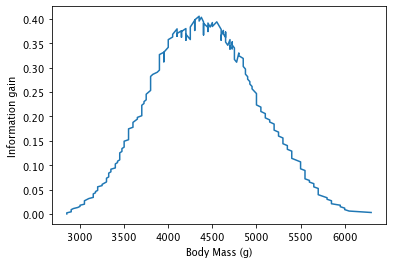

In [30]:
ax = all_information_gain.plot()
_ = ax.set_ylabel("Information gain")

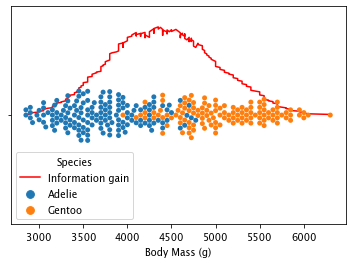

In [31]:
ax = (all_information_gain * -1).plot(color="red", label="Information gain")
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)

We can see that the maximum of the information gain corresponds to the split which best partition our data. So we can check the corresponding body mass threshold.

In [32]:
all_information_gain.idxmax()

4350.0

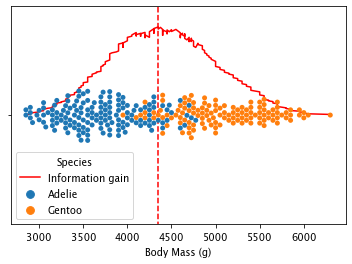

In [33]:
ax = (all_information_gain * -1).plot(color="red", label="Information gain")
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
ax.vlines(
    all_information_gain.idxmax(), -1, 1,
    color="red", linestyle="--"
)

## Decision Tree Regression

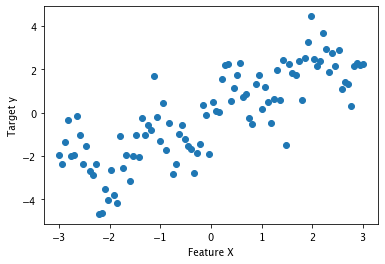

In [34]:
rnd = np.random.RandomState(42)
x = np.linspace(-3, 3, 100)
y_no_noise = np.sin(4 * x) + x
y = y_no_noise + rnd.normal(size=len(x))
X = x.reshape(-1, 1)

plt.figure()
plt.xlabel('Feature X')
plt.ylabel('Target y')
_ = plt.scatter(X, y)

In [36]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=2)
reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

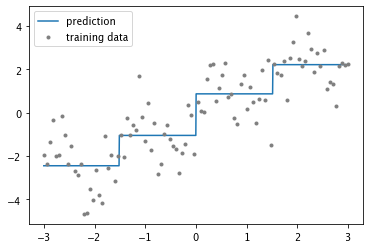

In [37]:
X_test = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_test = reg.predict(X_test)

plt.figure()
plt.plot(X_test.ravel(), y_test, color='tab:blue', label="prediction")
plt.plot(X.ravel(), y, 'C7.', label="training data")
_ = plt.legend(loc="best")

A single decision tree allows us to estimate the signal in a non-parametric way,
but clearly has some issues.  In some regions, the model shows high bias and
under-fits the data.
(seen in the long flat lines which don't follow the contours of the data),
while in other regions the model shows high variance and over-fits the data
(reflected in the narrow spikes which are influenced by noise in single points).

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Take the above example and repeat the training/testing by changing depth of the tree.
      </li>
      <li>
      What can you conclude?
      </li>
    </ul>
</div>

## Bagging classifiers

We saw that by increasing the depth of the tree, we are going to get an over-fitted model. A way to bypass the choice of a specific depth it to combine several trees together.

Let's use a simple classification dataset:

In [38]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

Different trees can be obtained by training on slightly different data. The slightly different datasets can be generated by randomly sampling with replacement: in statistics, this called a boostrap sample.

Before training several decision trees, we will train a single tree. However, instead of training this tree on `X_train`, we want to train it on a bootstrap sample.

In [39]:
def bootstrap_idx(X):
    indices = np.random.choice(
        np.arange(X.shape[0]), size=X.shape[0], replace=True
    )
    return indices

In [40]:
bootstrap_idx(X_train)

array([ 82, 102,  19,  60,  35, 104, 139, 146,  86, 113, 149,  19, 130,
        34,  87,   8,  40,  71, 148, 120,  64, 129,  64,  41,   3,  35,
       127, 104,  42,  97,  18,  52,  58, 121,  95,  95,  82,  69,  41,
       149, 146, 140, 120, 124, 131,  24,  40,  98,  16,  40, 107, 123,
        54, 133, 142,  22, 120,  59,  50,  91,  77,  30, 139,  71,  49,
        42,  82,  74, 129,  29,  29,  69, 110,  29,  27, 148, 135,  76,
       120, 116,  85,  28,  97,  31,   1, 110,  72,  62, 134,  31,  32,
         1, 113,  79, 148, 143,  10, 146,  49,  84, 122, 143,  26, 122,
        63, 129,  14,  42,  78,  33, 119, 124,  62,  94,  54,  11,   5,
       121,  72,  88, 105,  69,  24,  85,  72,   6,  20, 108,  87,  55,
        49,   9,  26,  75, 131, 123,  70, 116,  31,  22,  21, 147, 119,
       116, 113,  22,  65, 139, 119, 139])

In [41]:
from collections import Counter
Counter(bootstrap_idx(X_train))

Counter({94: 2,
         109: 1,
         5: 2,
         47: 1,
         91: 3,
         123: 1,
         73: 1,
         69: 1,
         22: 2,
         34: 1,
         121: 1,
         99: 2,
         79: 2,
         106: 2,
         28: 2,
         31: 1,
         46: 2,
         67: 2,
         11: 2,
         110: 2,
         113: 3,
         68: 2,
         8: 1,
         16: 2,
         48: 1,
         125: 2,
         2: 4,
         24: 1,
         62: 1,
         85: 1,
         0: 2,
         83: 2,
         33: 1,
         51: 1,
         49: 6,
         65: 1,
         97: 1,
         75: 1,
         39: 1,
         92: 1,
         146: 3,
         3: 2,
         40: 1,
         10: 4,
         84: 1,
         117: 2,
         122: 1,
         70: 1,
         82: 1,
         78: 1,
         15: 1,
         12: 1,
         61: 1,
         38: 2,
         89: 2,
         140: 1,
         144: 2,
         1: 1,
         102: 4,
         147: 1,
         27: 2,
         42: 1,


In [42]:
def bootstrap_sample(X, y):
    indices = bootstrap_idx(X)
    return X[indices], y[indices]

In [43]:
X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)

In [44]:
print(f'Classes distribution in the original data: {Counter(y_train)}')
print(f'Classes distribution in the bootstrap: {Counter(y_train_bootstrap)}')

Classes distribution in the original data: Counter({0: 75, 1: 75})
Classes distribution in the bootstrap: Counter({0: 80, 1: 70})


<div class="alert alert-success">
    <b>EXERCISE: Create a bagging classifier</b>:
    <br>
    A bagging classifier will train several decision tree classifiers, each of them on a different bootstrap sample.
     <ul>
      <li>
      Create several `DecisionTreeClassifier` and store them in a Python list;
      </li>
      <li>
      Loop over these trees and `fit` them on a bootstrap sample generated using `bootstrap_sample` function;
      </li>
      <li>
      To predict with this ensemble of trees on new data (testing set), you can provide the same set to each tree and call the `predict` method. Aggregate all predictions in a NumPy array;
      </li>
      <li>
      Once all predictions are available, you need to combine them into a single prediction: you can retain the class which predicted most often, which is called a majority vote;
      </li>
      <li>
      Finally, check the accuracy of your model.
      </li>
    </ul>
</div>

<div class="alert alert-success">
    <b>EXERCISE: using scikit-learn</b>:
    <br>
    After implementing your own bagging classifier, use a `BaggingClassifier` from scikit-learn to fit the above data.
</div>

## Random Forests

A very famous classifier is the random forest classifier. It is similar to the bagging classifier. In addition to the bootstrap, the random forest will use a subset of features (selected randomly) to find the best split.

<div class="alert alert-success">
    <b>EXERCISE: Create a random forest classifier</b>:
    <br>
    Use your previous code (Bagging code) to implement a Random Forest. You will need to modify one of the parameters of the `DecisionTreeClassifier` (check the corresponding documentation) such that only $\sqrt{F}$ features are used to find the best split, where $F$ is the number of features in the dataset.
</div>

<div class="alert alert-success">
    <b>EXERCISE: using scikit-learn</b>:
    <br>
    After implementing your own random forest classifier, use a `RandomForestClassifier` from scikit-learn to fit the above data.
</div>

In [ ]:
from figures import plot_forest_interactive
plot_forest_interactive()

## Another option: Gradient Boosting

Another Ensemble method that can be useful is *Boosting*: here, rather than
looking at (say) 200 parallel estimators, we construct a chain of 200 estimators
which iteratively refine the results of the previous estimator.
The idea is that by sequentially applying very fast, simple models, we can get a
total model error which is better than any of the individual pieces.

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=.2)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.9


<div class="alert alert-success">
    <b>ACCELERATE GRADIENT BOOSTING</b>:
    <ul>
        <li>Which solution would you use to accelerate the training speed of gradient boosting algorithm.</li>
    </ul>
</div>

Scikit-learn provides `HistGradientBoostingClassifier` which is an approximate gradient boosting algorithm similar to `lightgbm` and `xgboost`.

In [46]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.9
